# Cats vs Dogs Classification

In this notebook, you will not only learn about how to build a model to classify Cats and Dogs, but also how the Preprocessing and Dropout will improve your model while training and producing a better network.

# Import Libraries

## Install Tensorflow 2

If Tensorflow 2 have not installed, then install it first.

In [1]:
!pip install tensorflow-gpu -q

     |████████████████████████████████| 421.8MB 34kB/s 
     |████████████████████████████████| 3.9MB 35.7MB/s 
     |████████████████████████████████| 450kB 36.2MB/s 
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [2]:
import tensorflow as tf

tf.__version__

'2.1.0'

## Import other libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical

np.set_printoptions(precision=7)
np.random.seed(42)
%matplotlib inline

# Cats vs Dogs Tensorflow Dataset

This notebook uses cats_vs_dogs data from Tensorflow dataset, you can see the details here https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

## Create directory for dataset

In [0]:
import os

data_dir = 'dataset'

if not os.path.exists(data_dir):
  os.mkdir(data_dir)

## Download Cats vs Dogs dataset

In [5]:
dataset_name = 'cats_vs_dogs'

train_set, dataset_info =  tfds.load( 
              name = dataset_name, 
              split = 'train', 
              with_info = True, 
              data_dir = data_dir
          )

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to dataset/cats_vs_dogs/4.0.0.incompleteHS2M6U/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to dataset/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## Dataset Information

In [7]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

## Detailed Information

In [8]:
class_names =  dataset_info.features["label"].names

print('image shape    :', dataset_info.features['image'].shape)
print('image dtype    :', dataset_info.features['image'].dtype)
print()
print('num class      : ',dataset_info.features["label"].num_classes)
print('class label    :', dataset_info.features["label"].names)
print()
print('num train data :', dataset_info.splits["train"].num_examples)

image shape    : (None, None, 3)
image dtype    : <dtype: 'uint8'>

num class      :  2
class label    : ['cat', 'dog']

num train data : 23262


## Show Images

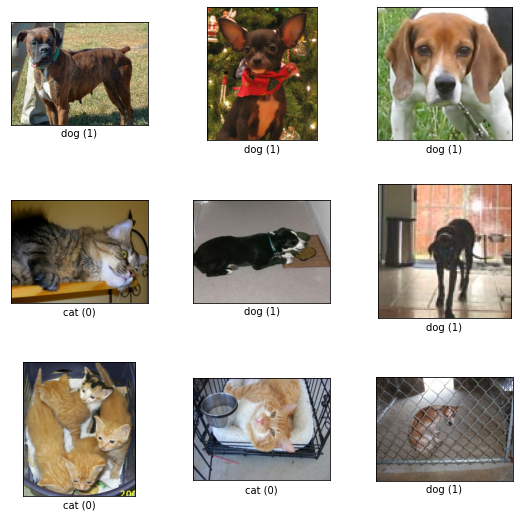

In [6]:
fig = tfds.show_examples(dataset_info, train_set)

As we can see, the image sizes differ from one another, so we have to resize all the images to the same size.

# Preprocess Image

Convert and Resize Data

In [0]:
input_shape = (128, 128, 3)

## Convert Data Train

In [0]:
X_train_ori = []
y_train_ori = []

for example in tfds.as_numpy(train_set):
    new_img = example['image']
    new_img = cv.resize(new_img, input_shape[:2],interpolation = cv.INTER_AREA) 
    X_train_ori.append(new_img)
    y_train_ori.append(example['label'])

del train_set

# Convert train data to numpy array
X_train_ori = np.asarray(X_train_ori)
y_train_ori = np.asarray(y_train_ori)

# One hot label
y_train_hot = to_categorical(y_train_ori)

# Split Train Data into Train, Val, and Test

In [11]:
# Set the length of Train, Val, and Test data
dataset_size = len(X_train_ori)
train_idx = int(0.7 * dataset_size)
val_idx = int(0.1 * dataset_size) + train_idx

# Split for val data
X_val = X_train_ori[train_idx:val_idx, :]
y_val = y_train_hot[train_idx:val_idx]

# Split for test data
X_test = X_train_ori[val_idx:, :]
y_test = y_train_hot[val_idx:]

# Split for train data
X_train = X_train_ori[:train_idx, :]
y_train = y_train_hot[:train_idx]

print('X_train.shape =',X_train.shape)
print('X_val.shape =',X_val.shape)
print('X_test.shape =',X_test.shape)

print('y_train.shape =',y_train.shape)
print('y_val.shape =',y_val.shape)
print('y_test.shape =',y_test.shape)

X_train.shape = (16283, 128, 128, 3)
X_val.shape = (2326, 128, 128, 3)
X_test.shape = (4653, 128, 128, 3)
y_train.shape = (16283, 2)
y_val.shape = (2326, 2)
y_test.shape = (4653, 2)


# Classification Model

In [12]:
model1 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),    
    Dense(units=2, activation='softmax')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

In [13]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = []

his = model1.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))
history.append(his)

Train on 16283 samples, validate on 2326 samples
Epoch 1/10
16283/16283 [==============================] - 42s 3ms/sample - loss: 3.9798 - accuracy: 0.5264 - val_loss: 0.6916 - val_accuracy: 0.5378
Epoch 2/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6859 - accuracy: 0.5421 - val_loss: 0.6809 - val_accuracy: 0.5619
Epoch 3/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6750 - accuracy: 0.5606 - val_loss: 0.6784 - val_accuracy: 0.5254
Epoch 4/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6576 - accuracy: 0.5777 - val_loss: 0.7008 - val_accuracy: 0.5817
Epoch 5/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6337 - accuracy: 0.6052 - val_loss: 0.6582 - val_accuracy: 0.6075
Epoch 6/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6173 - accuracy: 0.6149 - val_loss: 0.7247 - val_accuracy: 0.5520
Epoch 7/10
16283/16283 [==============================] -

Looks pretty good, right? In just 10 epochs we've got ~70% of train accuracy

But why the validation loss getting bigger and the validation accuracy is not increasing?

Yeah, this is what we called overfitting.

# Overfitting Challenge

<font color = 'red'>Overfitting</font> is a general problem in machine learning, not just in neural networks. The problem is inherent in the way machine learning models are developed: A set of training data is used to train the model. The goal is to have a model that can be used on data that <font color = 'red'>hasn't been seen </font> before. <font color = 'red'>Overfitting</font> refers to the problem of having the model trained to work so well on the training data that is start to work more <font color = 'red'>poorly</font> on data it <font color = 'red'>hasn't seen before</font>.

<p align=center>
<img src="http://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-03-at-7.52.01-PM-e1522832332857.png" width='800'>
</p>

<font color = 'red'>Overfitting</font> can also be seen from the <font color = 'blue'>difference</font> of <font color = 'red'>training error </font> and the <font color = 'red'>test error </font> when you are training the model, which the <font color = 'red'>training error</font> value is getting <font color = 'blue'>smaller</font> while the <font color = 'red'>test/validation error</font> is getting <font color = 'blue'>bigger</font> as illustrated below.

<p align=center>
<img src="http://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-04-at-2.43.37-PM-768x592.png" width='400'>
</p>

There are some techniques to prevent overfitting:
* Add more data
* use Data Augmentation
* use Batch Normalization & Standardization
* use Dropout
* use architecture that generalize well
* reduce architecture complexity
* Early stopping

source : http://primo.ai/index.php?title=Overfitting_Challenge

Let's add some Dropout to our network!

In [14]:
model2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61504)            

In [15]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

his = model2.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))
history.append(his)

Train on 16283 samples, validate on 2326 samples
Epoch 1/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 1.9792 - accuracy: 0.5095 - val_loss: 0.6882 - val_accuracy: 0.5417
Epoch 2/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6930 - accuracy: 0.5105 - val_loss: 0.6903 - val_accuracy: 0.5439
Epoch 3/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6916 - accuracy: 0.5276 - val_loss: 0.6882 - val_accuracy: 0.5417
Epoch 4/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6913 - accuracy: 0.5193 - val_loss: 0.6906 - val_accuracy: 0.5163
Epoch 5/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6903 - accuracy: 0.5266 - val_loss: 0.6821 - val_accuracy: 0.5628
Epoch 6/10
16283/16283 [==============================] - 34s 2ms/sample - loss: 0.6878 - accuracy: 0.5413 - val_loss: 0.6785 - val_accuracy: 0.5533
Epoch 7/10
16283/16283 [==============================] -

After adding some Dropout to our network, now the model is not overfit. So, what is Dropout? How can it handle the overfitting?

# Dropout

The key idea of <font color = 'blue'>Dropout</font> is to randomly drop units (along with their connections) from the neural network during training. This significantly reduces overfitting and gives major improvements over other regularization methods.

![alt text](http://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)

source : http://primo.ai/index.php?title=Dropout

The network performance is so bad since it only gets <font color = 'red'>~60% accuracy</font>. But actually we can make the network convergence faster than this.

How about <font color = 'blue'>normalize</font> the data? Would it help the model to <font color = 'blue'>convergence faster</font>? Let's see.

# Normalize Data

In [0]:
mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)

X_train = ((X_train - mean_pixel) / std_pixel).astype('float32')

X_val = ((X_val - mean_pixel) / std_pixel).astype('float32')

X_test = ((X_test - mean_pixel) / std_pixel).astype('float32')

Re-define the model

In [17]:
model3 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 61504)            

In [18]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

his = model3.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))
history.append(his)

Train on 16283 samples, validate on 2326 samples
Epoch 1/10
16283/16283 [==============================] - 36s 2ms/sample - loss: 0.6866 - accuracy: 0.5584 - val_loss: 0.6123 - val_accuracy: 0.6595
Epoch 2/10
16283/16283 [==============================] - 35s 2ms/sample - loss: 0.5883 - accuracy: 0.7018 - val_loss: 0.4977 - val_accuracy: 0.7661
Epoch 3/10
16283/16283 [==============================] - 35s 2ms/sample - loss: 0.5041 - accuracy: 0.7608 - val_loss: 0.4685 - val_accuracy: 0.7872
Epoch 4/10
16283/16283 [==============================] - 35s 2ms/sample - loss: 0.4555 - accuracy: 0.7956 - val_loss: 0.4158 - val_accuracy: 0.8186
Epoch 5/10
16283/16283 [==============================] - 35s 2ms/sample - loss: 0.4155 - accuracy: 0.8153 - val_loss: 0.4194 - val_accuracy: 0.8108
Epoch 6/10
16283/16283 [==============================] - 35s 2ms/sample - loss: 0.3821 - accuracy: 0.8352 - val_loss: 0.3879 - val_accuracy: 0.8255
Epoch 7/10
16283/16283 [==============================] -

Let's see the training accuracy and loss for our three models!

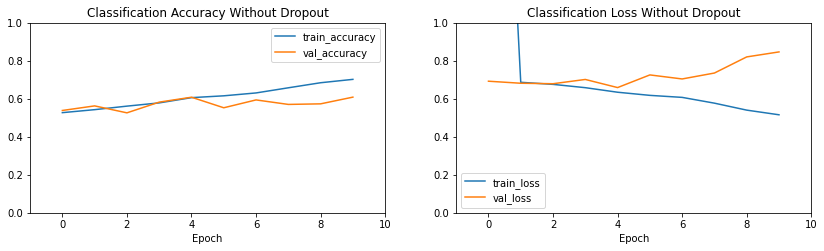

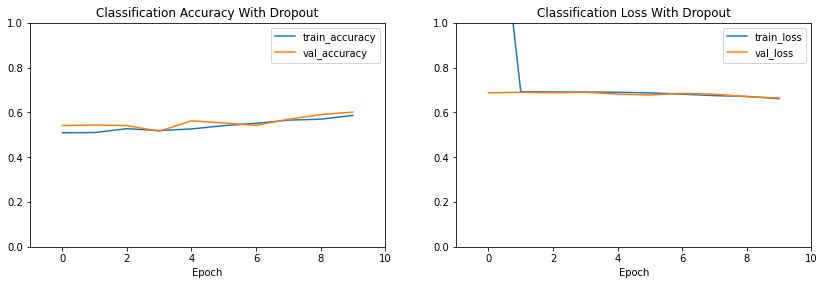

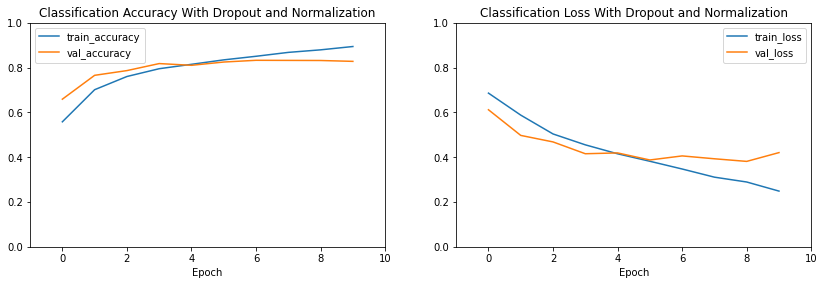

In [19]:
model_name = ["Without Dropout", "With Dropout", "With Dropout and Normalization"]

plt.rcParams['figure.figsize'] = [14, 14]
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, name in enumerate(model_name):
  plt.subplot(3, 2, i*2+1)
  plt.axis([-1, 10, 0, 1])
  plt.plot(history[i].history['accuracy'], label='train_accuracy')
  plt.plot(history[i].history['val_accuracy'], label='val_accuracy')
  plt.title("Classification Accuracy " + model_name[i])
  plt.xlabel('Epoch')
  plt.legend()

  plt.subplot(3, 2, i*2+2)
  plt.axis([-1, 10, 0, 1])
  plt.plot(history[i].history['loss'], label='train_loss')
  plt.plot(history[i].history['val_loss'], label='val_loss')
  plt.title("Classification Loss " + model_name[i])
  plt.xlabel('Epoch')
  plt.legend()
  
  plt.show()

As we can see, our first model is <font color = 'red'>overfitting</font> on the first row of the graphic. After adding <font color = 'blue'>dropout</font>, the model is not <font color = 'red'>overfitting</font> anymore. However, it is not showing performance as well as the second row of graphic. After we <font color = 'blue'>normalize</font> the data, the training result exhibit a <font color = 'blue'>better performance</font> than the two previous models. So, what is <font color = 'blue'>Data Normalization</font>?

# Data Normalization

In the simplest cases, <font color = 'blue'>normalization</font> means <font color = 'blue'>adjusting values on different scales to a common scale</font>. In more complicated cases, normalization may refer to <font color = 'blue'>more sophisticated adjustments where the intention is to bring the entire probability distributions of adjusted values into alignment</font>. In the case of normalization of scores in educational assessment, there may be an intention to align distributions to a normal distribution.

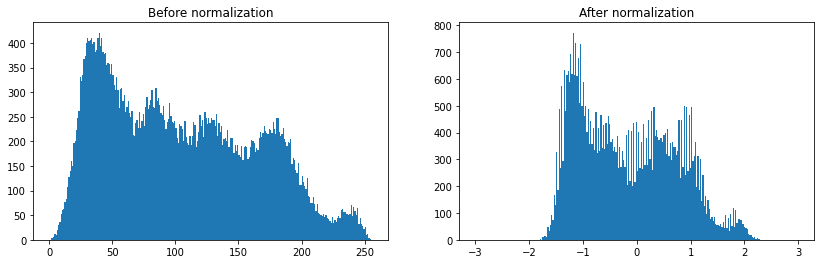

In [20]:
plt.rcParams['figure.figsize'] = [14, 4]
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(121)
plt.hist(X_train_ori[0].ravel(),256,[0,256])
plt.title("Before normalization")

plt.subplot(122)
plt.hist(X_train[0].ravel(),256,[-3,3])
plt.title("After normalization")
plt.show()

To use numeric data for machine regression, you usually need to <font color = 'blue'>normalize</font> the data. Otherwise, the numbers with <font color = 'blue'>larger ranges</font> may tend to <font color = 'red'>dominate</font> the Euclidian distance between feature vectors, their effects can be magnified at the expense of the other fields, and the steepest descent optimization may have difficulty converging. There are a number of ways to normalize and standardize data for ML, including <font color = 'blue'>min-max normalization</font>, <font color = 'blue'>mean normalization</font>, <font color = 'blue'>standardization</font>, and <font color = 'blue'>scaling to unit length</font>. This process is often called <font color = 'blue'>feature scaling</font>.

<font color = 'blue'>Normalization/Standardization</font> is beneficial in many cases. It <font color = 'blue'>improves the numerical stability</font> of the model and often reduces training time. However, standardization isn’t always great. It can harm the performance of distance-based clustering algorithms by assuming equal importance of features. If there are <font color = 'blue'>inherent importance differences between features</font>, it’s generally <font color = 'red'>not a good idea</font> to do standardization.

# Evaluate Model

## Model Performance without Dropout

In [21]:
train_scores = model1.evaluate(X_train, y_train, batch_size=16, verbose=1)
test_scores  = model1.evaluate(X_test, y_test, batch_size=16, verbose=1)
val_scores   = model1.evaluate(X_val, y_val, batch_size=16, verbose=1)

print('Train Loss: %.5f with Accuracy: %.1f%%' % (train_scores[0], (train_scores[1]*100)))
print('Test  Loss: %.5f with Accuracy: %.1f%%' % (test_scores[0], (test_scores[1]*100)))
print('Val   Loss: %.5f with Accuracy: %.1f%%' % (val_scores[0], (val_scores[1]*100)))

2326/2326 [==============================] - 2s 979us/sample - loss: 9.1928 - accuracy: 0.4966
Train Loss: 9.00727 with Accuracy: 50.0%
Test  Loss: 8.88738 with Accuracy: 50.1%
Val   Loss: 9.19276 with Accuracy: 49.7%


## Model Performance with Dropout

In [22]:
train_scores = model2.evaluate(X_train, y_train, batch_size=16, verbose=1)
test_scores  = model2.evaluate(X_test, y_test, batch_size=16, verbose=1)
val_scores   = model2.evaluate(X_val, y_val, batch_size=16, verbose=1)

print('Train Loss: %.5f with Accuracy: %.1f%%' % (train_scores[0], (train_scores[1]*100)))
print('Test  Loss: %.5f with Accuracy: %.1f%%' % (test_scores[0], (test_scores[1]*100)))
print('Val   Loss: %.5f with Accuracy: %.1f%%' % (val_scores[0], (val_scores[1]*100)))

2326/2326 [==============================] - 2s 915us/sample - loss: 1.3404 - accuracy: 0.5000
Train Loss: 1.32929 with Accuracy: 50.1%
Test  Loss: 1.30075 with Accuracy: 50.3%
Val   Loss: 1.34042 with Accuracy: 50.0%


## Model Performance with Dropout and Data Normalization

In [23]:
train_scores = model3.evaluate(X_train, y_train, batch_size=16, verbose=1)
test_scores  = model3.evaluate(X_test, y_test, batch_size=16, verbose=1)
val_scores   = model3.evaluate(X_val, y_val, batch_size=16, verbose=1)

print('Train Loss: %.5f with Accuracy: %.1f%%' % (train_scores[0], (train_scores[1]*100)))
print('Test  Loss: %.5f with Accuracy: %.1f%%' % (test_scores[0], (test_scores[1]*100)))
print('Val   Loss: %.5f with Accuracy: %.1f%%' % (val_scores[0], (val_scores[1]*100)))

2326/2326 [==============================] - 2s 907us/sample - loss: 0.4208 - accuracy: 0.8285
Train Loss: 0.19084 with Accuracy: 91.9%
Test  Loss: 0.43671 with Accuracy: 82.3%
Val   Loss: 0.42085 with Accuracy: 82.8%


If you realize, the third model we have trained with the <font color = 'blue'>normalized</font> data is still <font color = 'red'>overfitting</font> even although we have added <font color = 'blue'>Dropout</font>. Are there any another ways to handle <font color = 'red'>overfitting</font>? Yes, for the next tutorial we will do <font color = 'blue'>Data Augmentation</font> to prevent <font color = 'red'>overfitting</font>. Let's see how we do this.

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/malikanhar/>2019 - MALIK</a> </p>